# Import libraries

In [1]:
import pandas as pd
from pylab import *
import seaborn as sns
sns.set(style="whitegrid")
import gc
import scipy
from scipy.stats.stats import pearsonr, spearmanr
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std

pd.set_option('display.max_columns', None)
%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\Users\g.triulzi\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['info', 'linalg', 'power', 'fft', 'random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Define functions

In [2]:
# there is a bug with the command to input exogenous observation and obtain the prediction interval
# the solution is described in the following three posts and it uses the function defined here
# description of the bug: https://github.com/statsmodels/statsmodels/issues/987
# solution: https://stackoverflow.com/questions/32593522/return-std-and-confidence-intervals-for-out-of-sample-prediction-in-statsmodels
# jupyter notebook describing solutions: http://nbviewer.jupyter.org/gist/thatneat/10286720
# see also: https://ishaan.xyz/blog/confidence-intervals-vs-prediction-intervals-in-python/

def transform_exog_to_model(fit, exog):
    transform=True
    self=fit

    # The following is lifted straight from statsmodels.base.model.Results.predict()
    if transform and hasattr(self.model, 'formula') and exog is not None:
        from patsy import dmatrix
        exog = dmatrix(self.model.data.orig_exog.design_info.builder,
                       exog)

    if exog is not None:
        exog = np.asarray(exog)
        if exog.ndim == 1 and (self.model.exog.ndim == 1 or
                               self.model.exog.shape[1] == 1):
            exog = exog[:, None]
        exog = np.atleast_2d(exog)  # needed in count model shape[1]

    # end lifted code
    return exog

# Define import and export paths

In [3]:
import_path = '/Users/g.triulzi/Dropbox (MIT)/Paper Predicting K with Patents/Data/Input/'
export_path = '/Users/g.triulzi/Dropbox (MIT)/Paper Predicting K with Patents/Data/Output/'

# Import and manipulate data

### Patent variables for all USPTO patents

In [4]:
# Read file with information on all utility patents granted by the USPTO between 1975 and 2015
PATENT_INFO = pd.read_csv(import_path+'All_patents_info.csv')
PATENT_INFO.drop_duplicates('patent_number', keep = 'first', inplace=True)
idx_letters = PATENT_INFO['mainclass_id'].astype(str).str.contains('a|b|c|d|e|f|g|h|i|j|k|l|m|n|o|p|q|r|s|t|u|v|w|x|y|z|/|;|-|nan', na=False, case=False)
PATENT_INFO['mainclass_id'][~idx_letters] = PATENT_INFO['mainclass_id'][~idx_letters].astype(int).astype(str)
PATENT_INFO['mainclass_id'] = PATENT_INFO['mainclass_id'].astype(str)
PATENT_INFO['grant_year'] = PATENT_INFO['grant_date'].astype(str).apply(lambda x: x[:4])
PATENT_INFO['patent_number'] = PATENT_INFO['patent_number'].astype(int)

C:\Users\g.triulzi\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


### Patent sets for 30 domains

In [5]:
# Read file with list of patents for each domain
PATENT_SET_30_DOMAINS = pd.read_csv(import_path+'Domains_patent_info.csv')
PATENT_SET_30_DOMAINS['patent_number'] = PATENT_SET_30_DOMAINS['patent_number'].astype(int)

### Performance Improvement Rate for 30 domains

In [6]:
# Read file with observed TIRs for each domain
PERFORMANCE_DOMAINS = pd.read_csv(import_path+'PERFORMANCE_DOMAINS_K_Kr2.csv')
PERFORMANCE_DOMAINS['log_K'] = log(PERFORMANCE_DOMAINS['K'])

### Patent sets for new domain(s)

In [7]:
PATENT_SET_NEW_DOMAINS = (pd.read_csv(import_path+'PATENT_SET_BIOEL_MED.csv', sep=',', header=0, encoding='ISO-8859-1'))
idx_letters = (PATENT_SET_NEW_DOMAINS['patent_id'].astype(str)
               .str.contains('a|b|c|d|e|f|g|h|i|j|k|l|m|n|o|p|q|r|s|t|u|v|w|x|y|z|/|;|-|nan', na=False, case=False))
PATENT_SET_NEW_DOMAINS = PATENT_SET_NEW_DOMAINS[~idx_letters]
PATENT_SET_NEW_DOMAINS.rename(columns={'patent_id':'patent_number'},inplace=True)
PATENT_SET_NEW_DOMAINS['patent_number'] = PATENT_SET_NEW_DOMAINS['patent_number'].astype(int)

### Merge data

In [9]:
PATENT_SET_NEW_DOMAINS = (pd.merge(PATENT_SET_NEW_DOMAINS, PATENT_INFO, 
                             how = 'left', left_on = 'patent_number', right_on = 'patent_number'))

# Train regression with data from 30 domains

In [37]:
ti = time.time()

y = 'log_K'
x1 = 'meanSPNPcited_1year_before_randomized_zscore_RPbyYear'
confidence_level = 0.05

DF_mean_centrality_30_DOMAINS = PATENT_SET_30_DOMAINS[['Domain',x1]].groupby('Domain').agg('mean').reset_index()
REGRESSION_DATA = (pd.merge(PERFORMANCE_DOMAINS[['Domain',y]],DF_mean_centrality_30_DOMAINS,
                                           how = 'left', left_on = 'Domain', right_on = 'Domain'))
REGRESSION_DATA['index'] = list(range(REGRESSION_DATA.shape[0]))

list_predictors = ([x1]) 
num_predictors = len(list_predictors)

equation = y + ' ~ ' 
for i in list(range(num_predictors)):
    if i!=num_predictors-1:
        equation = equation + list_predictors[i] + ' + '
    else: equation = equation + list_predictors[i]

lm = smf.ols(formula=equation, data=REGRESSION_DATA, missing='drop').fit()    

# Store confidence and prediction intervals
REGRESSION_DATA['predicted_log_K'] = lm.predict()
from statsmodels.stats.outliers_influence import summary_table
post_estimation_table, post_estimation_data, post_estimation_variables = summary_table(lm, alpha=confidence_level)
REGRESSION_DATA['ci_low'] = list(post_estimation_data[:,4])
REGRESSION_DATA['ci_high'] = list(post_estimation_data[:,5])
REGRESSION_DATA['pi_low'] = list(post_estimation_data[:,6])
REGRESSION_DATA['pi_hi'] = list(post_estimation_data[:,7])

# get robust estimates
robust_lm = lm.get_robustcov_results(cov_type='HC1')
# https://stackoverflow.com/questions/46861158/robust-linear-regression-results-in-python-and-stata-do-not-agree

# Store residuals
REGRESSION_DATA.sort_values('index',inplace=True)
REGRESSION_DATA['predicted_log_K_HSR'] = robust_lm.predict()
REGRESSION_DATA['residuals_HSR'] = robust_lm.resid
REGRESSION_DATA['pearson_residuals_HSR'] = robust_lm.resid_pearson

# Store confidence and prediction intervals
post_estimation_table, post_estimation_data, post_estimation_variables = summary_table(robust_lm, alpha=confidence_level)
REGRESSION_DATA['ci_low_HSR'] = list(post_estimation_data[:,4])
REGRESSION_DATA['ci_high_HSR'] = list(post_estimation_data[:,5])
REGRESSION_DATA['pi_low_HSR'] = list(post_estimation_data[:,6])
REGRESSION_DATA['pi_hi_HSR'] = list(post_estimation_data[:,7])

tf = time.time()
(tf-ti)/60

0.0008975823720296223

### Compute confidence intervals in linear scale

In [11]:
x = 'meanSPNPcited_1year_before_randomized_zscore_RPbyYear'

DF_estimated_K_30_DOMAINS = pd.DataFrame()
for domain in PATENT_SET_30_DOMAINS.Domain.unique():
    x1_domain = DF_mean_centrality_30_DOMAINS[x][DF_mean_centrality_30_DOMAINS.Domain==domain]
    transformed_exog = transform_exog_to_model(lm, {x1:x1_domain})
    pred_std_logscale, pred_interval_low_logscale, pred_interval_high_logscale = (wls_prediction_std(lm, exog=transformed_exog, 
                                                                          weights=[1], alpha=confidence_level))
    predicted_outcome_logscale = lm.predict(exog={x1:x1_domain})
    predicted_outcome_linearscale = exp(predicted_outcome_logscale)*exp((pred_std_logscale**2)/2)
    pred_interval_low_linearscale = exp(pred_interval_low_logscale)*exp((pred_std_logscale**2)/2)
    pred_interval_high_linearscale = exp(pred_interval_high_logscale)*exp((pred_std_logscale**2)/2)

    DF = pd.DataFrame({'Domain':domain,
                       'predicted_K':predicted_outcome_linearscale,
                       'pred_std':pred_std_logscale,
                       'pi_low_linearscale':pred_interval_low_linearscale,
                       'pi_high_linearscale':pred_interval_high_linearscale},index=[domain])
    
    DF_estimated_K_30_DOMAINS = DF_estimated_K_30_DOMAINS.append(DF)

REGRESSION_DATA = (pd.merge(REGRESSION_DATA, DF_estimated_K_30_DOMAINS, 
                             how = 'left', left_on = 'Domain', right_on = 'Domain'))
REGRESSION_DATA['ci_low_linearscale'] = exp(REGRESSION_DATA['ci_low'])*exp((REGRESSION_DATA['pred_std']**2)/2)
REGRESSION_DATA['ci_high_linearscale'] = exp(REGRESSION_DATA['ci_high'])*exp((REGRESSION_DATA['pred_std']**2)/2)


# with robust estimates
DF_estimated_K_30_DOMAINS = pd.DataFrame()
for domain in PATENT_SET_30_DOMAINS.Domain.unique():
    x1_domain = DF_mean_centrality_30_DOMAINS[x][DF_mean_centrality_30_DOMAINS.Domain==domain]
    transformed_exog = transform_exog_to_model(robust_lm, {x1:x1_domain})
    pred_std_logscale, pred_interval_low_logscale, pred_interval_high_logscale = (wls_prediction_std(robust_lm, exog=transformed_exog, 
                                                                          weights=[1], alpha=confidence_level))
    predicted_outcome_logscale = robust_lm.predict(exog={x1:x1_domain})
    predicted_outcome_linearscale = exp(predicted_outcome_logscale)*exp((pred_std_logscale**2)/2)
    pred_interval_low_linearscale = exp(pred_interval_low_logscale)*exp((pred_std_logscale**2)/2)
    pred_interval_high_linearscale = exp(pred_interval_high_logscale)*exp((pred_std_logscale**2)/2)

    DF = pd.DataFrame({'Domain':domain,
                       'predicted_K_HSR':predicted_outcome_linearscale,
                       'pred_std_HSR':pred_std_logscale,
                       'pi_low_HSR_linearscale':pred_interval_low_linearscale,
                       'pi_high_HSR_linearscale':pred_interval_high_linearscale},index=[domain])
    
    DF_estimated_K_30_DOMAINS = DF_estimated_K_30_DOMAINS.append(DF)

REGRESSION_DATA = (pd.merge(REGRESSION_DATA, DF_estimated_K_30_DOMAINS, 
                             how = 'left', left_on = 'Domain', right_on = 'Domain'))
REGRESSION_DATA['ci_low_HSR_linearscale'] = exp(REGRESSION_DATA['ci_low_HSR'])*exp((REGRESSION_DATA['pred_std_HSR']**2)/2)
REGRESSION_DATA['ci_high_HSR_linearscale'] = exp(REGRESSION_DATA['ci_high_HSR'])*exp((REGRESSION_DATA['pred_std_HSR']**2)/2)

C:\Users\g.triulzi\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: The DesignInfo.builder attribute is deprecated starting in patsy v0.4.0; distinct builder objects have been eliminated and design_info.builder is now just a long-winded way of writing 'design_info' (i.e. the .builder attribute just returns self)
  from ipykernel import kernelapp as app


# Estimate K for new domain(s)

In [13]:
x = 'meanSPNPcited_1year_before_randomized_zscore_RPbyYear'

DF_mean_centrality_NEW_DOMAINS = PATENT_SET_NEW_DOMAINS[['Domain',x]].groupby('Domain').agg('mean').reset_index() 
list_NEW_DOMAINS = PATENT_SET_NEW_DOMAINS.Domain.unique()
DF_estimated_K_NEW_DOMAINS = pd.DataFrame()
for domain in list_NEW_DOMAINS:
    x1_domain = DF_mean_centrality_NEW_DOMAINS[x][DF_mean_centrality_NEW_DOMAINS.Domain==domain]
    transformed_exog = transform_exog_to_model(lm, {x1:x1_domain})
    pred_std_logscale, pred_interval_low_logscale, pred_interval_high_logscale = (wls_prediction_std(lm, exog=transformed_exog, 
                                                                          weights=[1], alpha=confidence_level))
    predicted_outcome_logscale = lm.predict(exog={x1:x1_domain})
    predicted_outcome_linearscale = exp(predicted_outcome_logscale)*exp((pred_std_logscale**2)/2)
    pred_interval_low_linearscale = exp(pred_interval_low_logscale)*exp((pred_std_logscale**2)/2)
    pred_interval_high_linearscale = exp(pred_interval_high_logscale)*exp((pred_std_logscale**2)/2)

    DF = pd.DataFrame({'Domain':domain,
                       x1:array(x1_domain),
                       'predicted_log_K':array(predicted_outcome_logscale),
                       'predicted_K':array(predicted_outcome_linearscale),
                       'pred_std':pred_std_logscale,
                       'pred_interval_low_logscale':pred_interval_low_logscale,
                       'pred_interval_high_logscale':pred_interval_high_logscale,
                       'pred_interval_low_linearscale':pred_interval_low_linearscale,
                       'pred_interval_high_linearscale':pred_interval_high_linearscale},index=[domain])
    
    DF_estimated_K_NEW_DOMAINS = DF_estimated_K_NEW_DOMAINS.append(DF)

# with robust estimates
DF_estimated_K_NEW_DOMAINS_HSR = pd.DataFrame()
for domain in list_NEW_DOMAINS:
    x1_domain = DF_mean_centrality_NEW_DOMAINS[x][DF_mean_centrality_NEW_DOMAINS.Domain==domain]
    transformed_exog = transform_exog_to_model(robust_lm, {x1:x1_domain})
    pred_std_logscale, pred_interval_low_logscale, pred_interval_high_logscale = (wls_prediction_std(robust_lm, exog=transformed_exog, 
                                                                          weights=[1], alpha=confidence_level))
    predicted_outcome_logscale = robust_lm.predict(exog={x1:x1_domain})
    predicted_outcome_linearscale = exp(predicted_outcome_logscale)*exp((pred_std_logscale**2)/2)
    pred_interval_low_linearscale = exp(pred_interval_low_logscale)*exp((pred_std_logscale**2)/2)
    pred_interval_high_linearscale = exp(pred_interval_high_logscale)*exp((pred_std_logscale**2)/2)

    DF = pd.DataFrame({'Domain':domain,
                       'predicted_log_K_HSR':array(predicted_outcome_logscale),
                       'predicted_K_HSR':array(predicted_outcome_linearscale),
                       'pred_std_HSR':pred_std_logscale,
                       'pred_interval_low_logscale_HSR':pred_interval_low_logscale,
                       'pred_interval_high_logscale_HSR':pred_interval_high_logscale,
                       'pred_interval_low_linearscale_HSR':pred_interval_low_linearscale,
                       'pred_interval_high_linearscale_HSR':pred_interval_high_linearscale},index=[domain])
    
    DF_estimated_K_NEW_DOMAINS_HSR = DF_estimated_K_NEW_DOMAINS_HSR.append(DF)

DF_estimated_K_NEW_DOMAINS = (pd.merge(DF_estimated_K_NEW_DOMAINS, DF_estimated_K_NEW_DOMAINS_HSR, 
                             how = 'left', left_on = 'Domain', right_on = 'Domain'))
DF_estimated_K_NEW_DOMAINS.sort_values('predicted_K',ascending=False,inplace=True)

C:\Users\g.triulzi\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: The DesignInfo.builder attribute is deprecated starting in patsy v0.4.0; distinct builder objects have been eliminated and design_info.builder is now just a long-winded way of writing 'design_info' (i.e. the .builder attribute just returns self)
  from ipykernel import kernelapp as app


In [28]:
DF_estimated_K_NEW_DOMAINS[['Domain','predicted_K_HSR']]

,Domain,predicted_K_HSR
2,Microwave_stimulation,1.534550
4,Ultrasound_stimulation,0.583406
3,Electrical_stimulation,0.317836
1,Optical_stimulation,0.182151
0,Magnetic_stimulation,0.044329


# Estimated densities of predicted improvement rates

C:\Users\g.triulzi\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]
C:\Users\g.triulzi\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:24: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


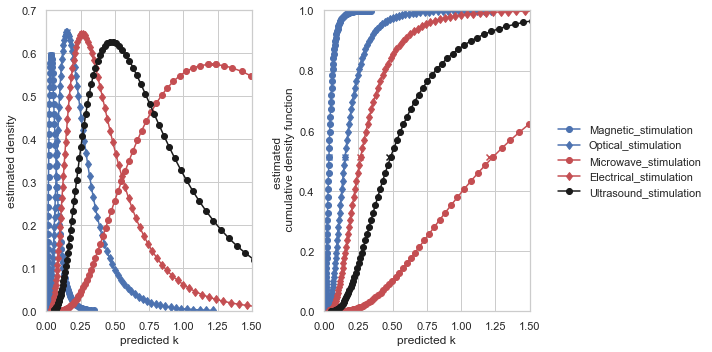

In [15]:
from scipy.stats import norm
color_list = ['b','g','r','m','y',]
c = ['bo-','bd-','ro-','rd-','ko-','kd-','go-','gd-','co-']

f, ax = subplots(figsize=(10, 5))

for i in range(len(list_NEW_DOMAINS)):
    domain = list_NEW_DOMAINS[i]
    mu = array(DF_estimated_K_NEW_DOMAINS_HSR['predicted_log_K_HSR'][DF_estimated_K_NEW_DOMAINS_HSR['Domain']==domain])
    sigma = array(DF_estimated_K_NEW_DOMAINS_HSR['pred_std_HSR'][DF_estimated_K_NEW_DOMAINS_HSR['Domain']==domain])
    x = np.linspace(mu-3.4*sigma,mu+3.4*sigma, 100)
    
    subplot (1,2,1)
    y = norm.pdf(x, mu, sigma)
    plot(exp(x),y,c[i],label=domain)
    pdf_mu = y[x >= mu][0]
    scatter([exp(mu)],[pdf_mu],c=c[i][0],marker='x',linewidths=2)
    ylim(0,0.7) 
    xlim(0,1.5)
    #legend(loc='upper right')
    xlabel('predicted k')
    ylabel('estimated density')

    subplot (1,2,2)
    y = norm.cdf(x, mu, sigma)
    plot(exp(x),y,c[i],label=domain)
    cdf_mu = y[x >= mu][0]
    scatter([exp(mu)],[cdf_mu],c=c[i][0],marker='x',linewidths=2)
    ylim(0,1)
    xlim(0,1.5)
    legend(loc='center right', frameon=False, borderaxespad=-16)
    xlabel('predicted k')
    ylabel('estimated \n cumulative density function')

tight_layout()

# Export
name_fig = 'density_estimated_rate_new_domains'
format_fig = '.pdf'
savefig(export_path+name_fig+format_fig, bbox_inches='tight', dpi=150)
format_fig = '.tiff'
savefig(export_path+name_fig+format_fig, bbox_inches='tight', dpi=400)
format_fig = '.svg'
savefig(export_path+name_fig+format_fig, bbox_inches='tight', dpi=150)

# Likelihood that focal domain is faster than other domain

In [16]:
from scipy import stats
from scipy.stats import norm
# See answers here to understand how prob that A>B is computed:
# https://stats.stackexchange.com/questions/26886/why-is-the-variance-of-x-y-equal-to-the-sum-of-the-variances-when-x-y-are-in/31328#31328
# https://stats.stackexchange.com/questions/50501/probability-of-one-random-variable-being-greater-than-another
DF_likelihood_diff = pd.DataFrame()
for focal_domain in list_NEW_DOMAINS:
    mu_focal = array(DF_estimated_K_NEW_DOMAINS_HSR['predicted_log_K_HSR'][DF_estimated_K_NEW_DOMAINS_HSR['Domain']==focal_domain])
    sigma_focal = array(DF_estimated_K_NEW_DOMAINS_HSR['pred_std_HSR'][DF_estimated_K_NEW_DOMAINS_HSR['Domain']==focal_domain])
    for other_domain in list(set(list_NEW_DOMAINS).difference([focal_domain])):
        mu_other = array(DF_estimated_K_NEW_DOMAINS_HSR['predicted_log_K_HSR'][DF_estimated_K_NEW_DOMAINS_HSR['Domain']==other_domain])
        sigma_other = array(DF_estimated_K_NEW_DOMAINS_HSR['pred_std_HSR'][DF_estimated_K_NEW_DOMAINS_HSR['Domain']==other_domain])
        mu_diff = mu_focal - mu_other
        sigma_diff = sigma_focal + sigma_other
        x = np.linspace(mu_diff-3.4*sigma_diff,mu_diff+3.4*sigma_diff, 100) #np.linspace(norm.ppf(0.0001),norm.ppf(0.9999), 100)
        y = norm.cdf(x, mu_diff, sigma_diff)
        cdf_zero = 1-(y[x >= 0][0])
        DF = (pd.DataFrame({'focal_domain':focal_domain,
                          'other_domain':other_domain,
                           'likelihood_focal_greater_other':cdf_zero},index=[focal_domain]))
        DF_likelihood_diff = DF_likelihood_diff.append(DF)

DF_likelihood_diff = DF_likelihood_diff[DF_likelihood_diff['focal_domain']!=DF_likelihood_diff['other_domain']]

In [17]:
# create pivot table
DF_pivot = DF_likelihood_diff.pivot('focal_domain', 'other_domain', 'likelihood_focal_greater_other')

# sort DF_pivot columns by predicted k of domains
sorted_columns = (array(DF_estimated_K_NEW_DOMAINS_HSR[['Domain','predicted_K_HSR']]
                        [DF_estimated_K_NEW_DOMAINS_HSR.Domain.isin(list_NEW_DOMAINS)]
                        .sort_values('predicted_K_HSR',ascending=False)['Domain']))
DF_pivot = DF_pivot[sorted_columns]

# sort DF_pivot rows by predicted k of domains
ix = list(range(len(sorted_columns)))
new_index = pd.DataFrame({'domain':sorted_columns,'ix':ix},index=[ix])
DF_pivot=(pd.merge(DF_pivot, new_index,
                                 how = 'outer', left_on = array(DF_pivot.index), 
                                 right_on = ['domain']))
DF_pivot.sort_values('ix',ascending=True,inplace=True)
del DF_pivot['ix']
DF_pivot.rename(columns={"domain":"focal_domain"},inplace=True)
DF_pivot.set_index('focal_domain',inplace=True)

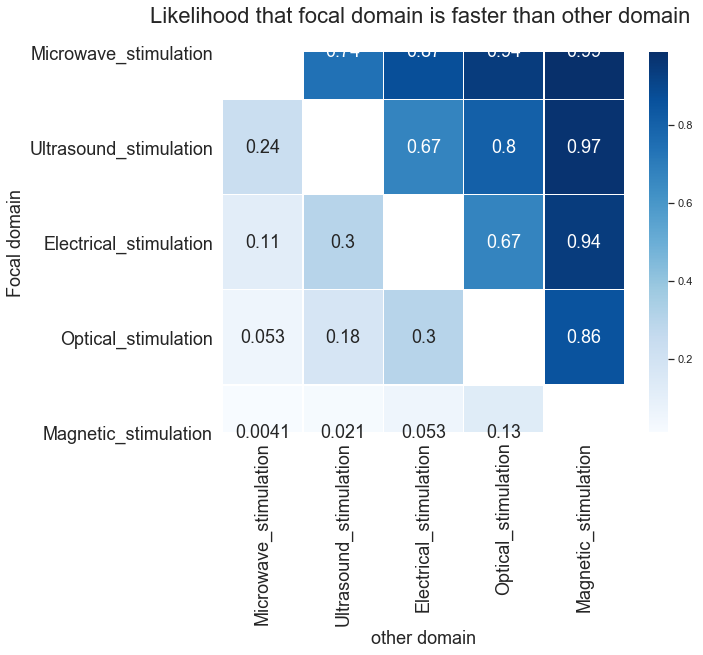

In [26]:
f, ax = subplots(figsize=(9, 7))

ax = sns.heatmap(DF_pivot, robust=True, annot=True, linewidths=.5, annot_kws={"size": 18}, cmap='Blues') #vmin=0, vmax=5
yticks(rotation=0,fontsize=18)
xticks(rotation=90,fontsize=18)
ylabel('Focal domain',fontsize=18)
xlabel('other domain',fontsize=18)
ax.set_title('Likelihood that focal domain is faster than other domain \n ',fontsize=22)
#sns.set(font_scale=3)

# Export
name_fig = 'likelihood_domain_faster_than_other_domain'
format_fig = '.pdf'
savefig(export_path+name_fig+format_fig, bbox_inches='tight', dpi=150)
format_fig = '.tiff'
savefig(export_path+name_fig+format_fig, bbox_inches='tight', dpi=400)

# Export results

In [19]:
# Export
name = 'REGRESSION_DATA'
extension = '.xlsx'
filename = export_path + name + extension
REGRESSION_DATA.to_excel(filename, index=False)

In [20]:
# Export
name = 'TABLE_estimated_k_meanSPNPcited_1year_before_randomized_zscore_RPbyYear'
extension = '.xlsx'
filename = export_path + name + extension
DF_estimated_K_NEW_DOMAINS.to_excel(filename, index=False)